In [10]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator, QiskitRuntimeService

# Cargar credenciales de IBM Quantum
service = QiskitRuntimeService()

## Paso 1: Mapear el problema a un formato nativo cuántico

En un programa cuántico, los circuitos cuánticos son el formato nativo en el que se representan las instrucciones cuánticas, y los operadores representan los observables que se medirán. Al crear un circuito, usualmente se crea un nuevo objeto `QuantumCircuit`, y luego se añaden instrucciones a este en secuencia.

El siguiente bloque de código crea un circuito que produce un estado de Bell, que es un estado en el que dos cúbits están completamente entrelazados entre sí.

**Nota: orden de los bits**

El SDK de Qiskit utiliza el orden de bits LSb 0, donde el dígito enésimo tiene valor $1 \ll n$ o $2^n$. Para más detalles, consulta el tema [Bit-ordering in the Qiskit SDK](https://qiskit.org/documentation/tutorials/circuits/3_summary_of_quantum_operations.html#Bit-ordering-in-Qiskit).


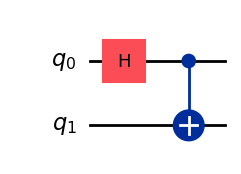

In [11]:
# Crear un circuito de prueba con dos quibits
qc = QuantumCircuit(2)

# Añaadir una compuerta de Hadamard al quibit 0
qc.h(0)

# Ejecutar una compuerta X controlada en el quibit 1 con el quibit 0 como control
qc.cx(0, 1)

# Regresar un diagrama del circuito empleando Matplotlib ("mpl"). Esto es la
# ultima linea de la celda, por lo que el diagrama se mostrara en la salida
qc.draw('mpl')

In [12]:
# Ajustar los seis diferentes observables
observables_labels = ['IZ', 'IX', 'ZI', 'XI', 'ZZ', 'XX']
observables = [SparsePauliOp(label) for label in observables_labels]

## Paso 2: Optimizar los circuitos y operadores

Al ejecutar circuitos en un dispositivo, es importante optimizar el conjunto de instrucciones que contiene el circuito y minimizar la profundidad general (aproximadamente el número de instrucciones) del mismo. Esto garantiza que se obtengan los mejores resultados posibles al reducir los efectos del error y el ruido. 

Además, las instrucciones del circuito deben ajustarse a la Arquitectura del Conjunto de Instrucciones (ISA, por sus siglas en inglés) del dispositivo de backend, considerando las compuertas base y la conectividad de los cúbits del dispositivo.

**Nota:** El siguiente ejemplo crea un dispositivo real para enviar un trabajo y transforma el circuito y los observables para adaptarse a la ISA de ese backend.


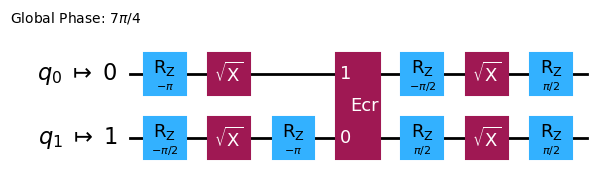

In [13]:
backend = service.least_busy(simulator=False, operational=True)
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
 
isa_circuit.draw("mpl", idle_wires=False)

## Paso 3: Ejecutar utilizando las primitivas cuánticas

Los computadores cuánticos pueden generar resultados aleatorios, por lo que generalmente se recopila una muestra de las salidas ejecutando el circuito múltiples veces. Puedes estimar el valor del observable utilizando la clase `Estimator`. 

El `Estimator` es una de las dos primitivas; la otra es `Sampler`, que se puede usar para obtener datos de un computador cuántico. Estos objetos poseen un método `run()` que ejecuta la selección de circuitos, observables y parámetros (si aplica), utilizando un bloque unificado primitivo (PUB, por sus siglas en inglés).


In [17]:
# Construir la instancia del estimador
estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 1000

mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

# Un bloque unificado (PUB) con un circuito para ejecutarse contra cinco observables
job = estimator.run([(isa_circuit, mapped_observables)])

# Usamos el job ID para obtener los resultados más tarde
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cx4kc8hpx23g008e6ka0


## Después de enviar un trabajo

Una vez que se envía un trabajo, puedes esperar a que se complete dentro de tu instancia actual de Python o usar el `job_id` para recuperar los datos más tarde. (Consulta la sección sobre recuperación de trabajos para más detalles).

Después de que el trabajo se complete, examina su salida a través del atributo `result()` del trabajo.


In [18]:
# Este es el resultado del trabajo enviado. Usted a sometido un PUB, 
# por lo que este contiene el resultado y alguna metadata 

job_results = job.result()

# Este es el resultado de único PUB, que posee 6 observables,
# por lo que contiene información sobre los 6

pub_result  = job_results[0]

## Paso 4: Analizar los resultados

El paso de análisis es típicamente donde puedes posprocesar tus resultados utilizando, por ejemplo, mitigación de errores de medición o extrapolación de ruido cero (ZNE, por sus siglas en inglés). También puedes integrar estos resultados en otro flujo de trabajo para un análisis más profundo o preparar un gráfico con los valores clave y los datos obtenidos. En general, este paso es específico de tu problema. En este ejemplo, se graficarán cada uno de los valores de expectativa que fueron medidos para nuestro circuito.

Los valores de expectativa y desviaciones estándar para los observables que especificaste en `Estimator` se acceden a través de los atributos `PubResult.data.evs` y `PubResult.data.stds` del resultado del trabajo. Para obtener los resultados de `Sampler`, utiliza la función `PubResult.data.meas.get_counts()`, que devolverá un diccionario de mediciones en forma de cadenas de bits como claves y sus correspondientes conteos como valores. Para más información, consulta [Introducción a Sampler](https://qiskit.org/documentation/).


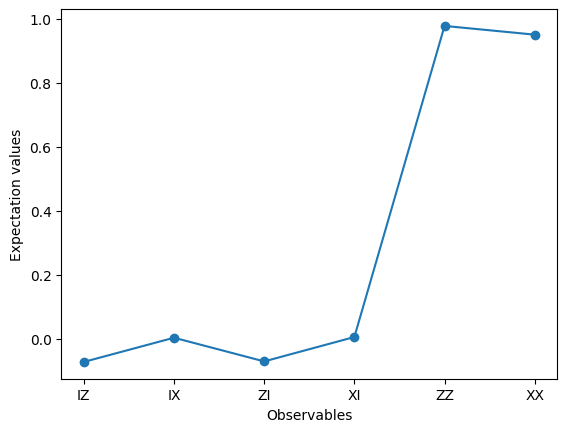

In [19]:
from matplotlib import pyplot as plt

values = pub_result.data.evs
erros = pub_result.data.stds

# Graficar los valores de los observables
plt.plot(observables_labels, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Expectation values')
plt.show()